<a href="https://colab.research.google.com/github/satuelisa/NLPF/blob/main/NLPF_03_R.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [28]:
install.packages("tidytext") # only install ONCE on your own computer
install.packages("tm") # only install ONCE on your own computer
install.packages("textdata") # this is new for Session 3, install now if using your own computer

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘NLP’, ‘slam’, ‘BH’


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [16]:
library(tidytext)
library(textdata)
library(dplyr) # needed for piping with %>%
interactive() # this is NOT an interactive R GUI so we cannot answer "Do you want to download" dialogues
tns <- getNamespace("textdata") # so, unless we run this on a local machine, we need to do more steps
assignInNamespace(x = "printer", value = function(...) 1, ns = tns) # a workaround from https://community.rstudio.com/t/is-there-a-way-to-make-the-choices-asked-for-in-the-package-always-yes/105442


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




[1] FALSE

The package contains an annotated list associating *sentiments* to (single) *words* for numerous different vocabularies (called *lexicons*). The way in which sentiments are quantified varies:

In [17]:
# s1 assigns a category to each
s1 <- get_sentiments("nrc")
head(s1)
s1 %>% count(sentiment, sort = TRUE)

word,sentiment
<chr>,<chr>
abacus,trust
abandon,fear
abandon,negative
abandon,sadness
abandoned,anger
abandoned,fear


sentiment,n
<chr>,<int>
negative,3316
positive,2308
fear,1474
anger,1245
trust,1230
sadness,1187
disgust,1056
anticipation,837
joy,687


In [18]:
# s2 assigns a numeric score
s2 <- get_sentiments("afinn")
head(s2)
s2 %>% count(value, sort = TRUE)

word,value
<chr>,<dbl>
abandon,-2
abandoned,-2
abandons,-2
abducted,-2
abduction,-2
abductions,-2


value,n
<dbl>,<int>
-2,966
2,448
-1,309
-3,264
1,208
3,172
4,45
-4,43
-5,16


In [20]:
# s3 is just positive/negative
s3 <- get_sentiments("bing")
head(s3)
s3 %>% count(sentiment)

word,sentiment
<chr>,<chr>
2-faces,negative
abnormal,negative
abolish,negative
abominable,negative
abominably,negative
abominate,negative


sentiment,n
<chr>,<int>
negative,4781
positive,2005


So, we could make use of these by assigning sentiments to words in sentences in a corpus to figure out what emotions might be expressed in the text. Let's mess around with product reviews from Amazon as an example.

In [35]:
library(tidyverse)
library(rvest)

Warning message in system("timedatectl", intern = TRUE):
“running command 'timedatectl' had status 1”
── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ forcats 0.5.1
✔ readr   2.1.2     

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ ggplot2::annotate() masks NLP::annotate()
✖ readr::col_factor() masks scales::col_factor()
✖ purrr::discard()    masks scales::discard()
✖ dplyr::filter()     masks stats::filter()
✖ dplyr::lag()        masks stats::lag()


Attaching package: ‘rvest’


The following object is masked from ‘package:readr’:

    guess_encoding




In [99]:
# we base this on a vignette from https://martinctc.github.io/blog/vignette-scraping-amazon-reviews-in-r/ 
webscrape <- function(ASIN){
  url <- paste0("https://www.amazon.ca/product-reviews/", ASIN, "/?pageNumber=1") # just the first page
  doc <- read_html(url)
  doc %>% 
    html_nodes("[class='a-size-base review-text review-text-content']") %>%
    html_text() -> content
  return(tibble(content))
}

In [110]:
# https://www.amazon.com/Practical-Natural-Language-Processing-Pragmatic/dp/1492054054/
first <- mutate(webscrape("1492054054"), title = "Practical NLP")

So this is already handily parsed into a tibble.

In [111]:
first

content,title
<chr>,<chr>
B/W edition...the feel of the pages of an authentic o rielly publication is duly missing..,Practical NLP
First copy started loosing pages from the first reading session and continued thereafter.Then I requested a replacement and same story happened again.Much as I am focused on the content of the book the form in which it comes is also important.You can't sell books that are loosing pages so easily.,Practical NLP
"This is the first time I got a book which cover is correct, but the content is completely wrong.How is it possible?The book I got was ""Infrastructure as Code"", see Photo., but the cover says Practical Natural Language Processing.Usually, I wouldn't give a bad review, but I read that many users complained about the book's quality. Well, I wouldn't suggest to buy the book until they fix their quality issues.",Practical NLP
Love the book but not sure why it’s in black and white and the images are so blurry..,Practical NLP
"Très déçu de la qualité d'impression de ce livre vendu et expédié par Amazon. En effet, les images sont à peine visibles (voir photo 1) en comparaison à celles disponibles sur les extraits publiques du livre (voir photo 2). Cela sans parler de l'épaisseur de pages et de la sensation globale de n'avoir pas un produit O'Reilly sur la main. Retour et remboursement demandé.",Practical NLP
"It covers a lot of subjects but very superficially, and uses almost exclusively outdated techniques.Still ok if you know absolutely nothing about the subject but it's nowhere wear a practical book, especially if you're looking for business applications.",Practical NLP
"... the word ""practical"" in the title might make you think about the word ""applied"", as in code. That was what I was expecting. This is a great book to give a manager to read about NLP. They will understand things at a high level after reading it. However it just does not get the job done for someone like myself looking to apply this knowledge.",Practical NLP
"About This BookThis was a highly regarded book when it came out in the summer of 2020, and I can see why. It's the generalist's guide to NLP, a high-level overview of the entire field. If you want to learn about natural language processing, this is where you start. There are books to read after this one, but this is your foundation.Who Is This For?The authors intent this book to be for anyone who is interested in or working in the field. However, they also have a list of prerequisites they want you to have to gain the maximum value from the book: an intermediate level of Python, knowledge of the general software development life cycle, a basic knowledge of machine learning, and some general knowledge of what NLP is. I can see where these can be useful, but I also agree with the authors that these are not completely necessary.Why Was This Written?The authors wrote this book to fill a perceived gap between what previous books offered versus what they think is required for working with natural language in production. From what I have seen from other books, I can agree.OrganizationThe macrostructure of this book is well thought out and is broken up into four parts: foundations, essentials, applied, and bringing it all together. I really like these sections and how they include a map of reading order in the preface. This is useful when you already have a little bit of knowledge and want to see how best to skip around without missing anything.Within the chapters, each one is different, but all end with a wrapping up section to summarize the chapter and give all the references. Having a summary at the end is great for helping the reader retain the information they just read. I never understood why some technical books leave this out.Did This Book Succeed?Yes, very much so. This is a foundational book for anyone learning natural language processing that paves the way for more detailed books when you want to drill down and specialize. It's well laid out and easy to navigate. T

Lets get some more for other books.

In [112]:
second <- mutate(webscrape("1491978236"), title = "NLP with PyTorch") # https://www.amazon.ca/Natural-Language-Processing-PyTorch-Applications/dp/1491978236/
third <- mutate(webscrape("1617294632"), title = "NLP in Action") # https://www.amazon.ca/Natural-Language-Processing-Action-Understanding/dp/1617294632/

We can now try to figure out how do the customers seem to *feel* about these books. Let's make a tibble with the book ID as a column and then combine the three books.

In [115]:
combo <- rbind(first, second, third)
combo %>% count(title)

title,n
<chr>,<int>
NLP in Action,10
NLP with PyTorch,10
Practical NLP,10


We need to add a column for which review is which so we can break them up into words and then associate sentiments to each word from the lexicons we loaded and still know from which review the words came from (in case we want to do something with that later on).

In [120]:
reviews <- combo %>% mutate(review = row_number())
data <- reviews %>% unnest_tokens(word, content)
head(data)

title,review,word
<chr>,<int>,<chr>
Practical NLP,1,b
Practical NLP,1,w
Practical NLP,1,edition
Practical NLP,1,the
Practical NLP,1,feel
Practical NLP,1,of


We should ditch the stop words before we add the sentiments, though.

In [122]:
clean <- data %>% filter(!word %in% stop_words$word)
head(clean)

title,review,word
<chr>,<int>,<chr>
Practical NLP,1,edition
Practical NLP,1,feel
Practical NLP,1,pages
Practical NLP,1,authentic
Practical NLP,1,rielly
Practical NLP,1,publication


In [125]:
categorical <- clean %>% inner_join(s1)
categorical %>% count(title, sentiment, sort = TRUE)

Joining, by = "word"


title,sentiment,n
<chr>,<chr>,<int>
Practical NLP,positive,67
NLP with PyTorch,positive,59
Practical NLP,trust,41
NLP in Action,positive,35
NLP with PyTorch,trust,23
NLP in Action,trust,20
NLP with PyTorch,negative,19
NLP with PyTorch,joy,16
Practical NLP,negative,13


On a quick glance it looks like the majority of the reviewers are positive about the books. Maybe this is easier to visualize if we use the scores instead?

Joining, by = "word"


title,review,word,value
<chr>,<int>,<chr>,<dbl>
Practical NLP,1,missing,-2
Practical NLP,2,focused,2
Practical NLP,3,natural,1
Practical NLP,3,bad,-3
Practical NLP,3,complained,-2
Practical NLP,4,love,3


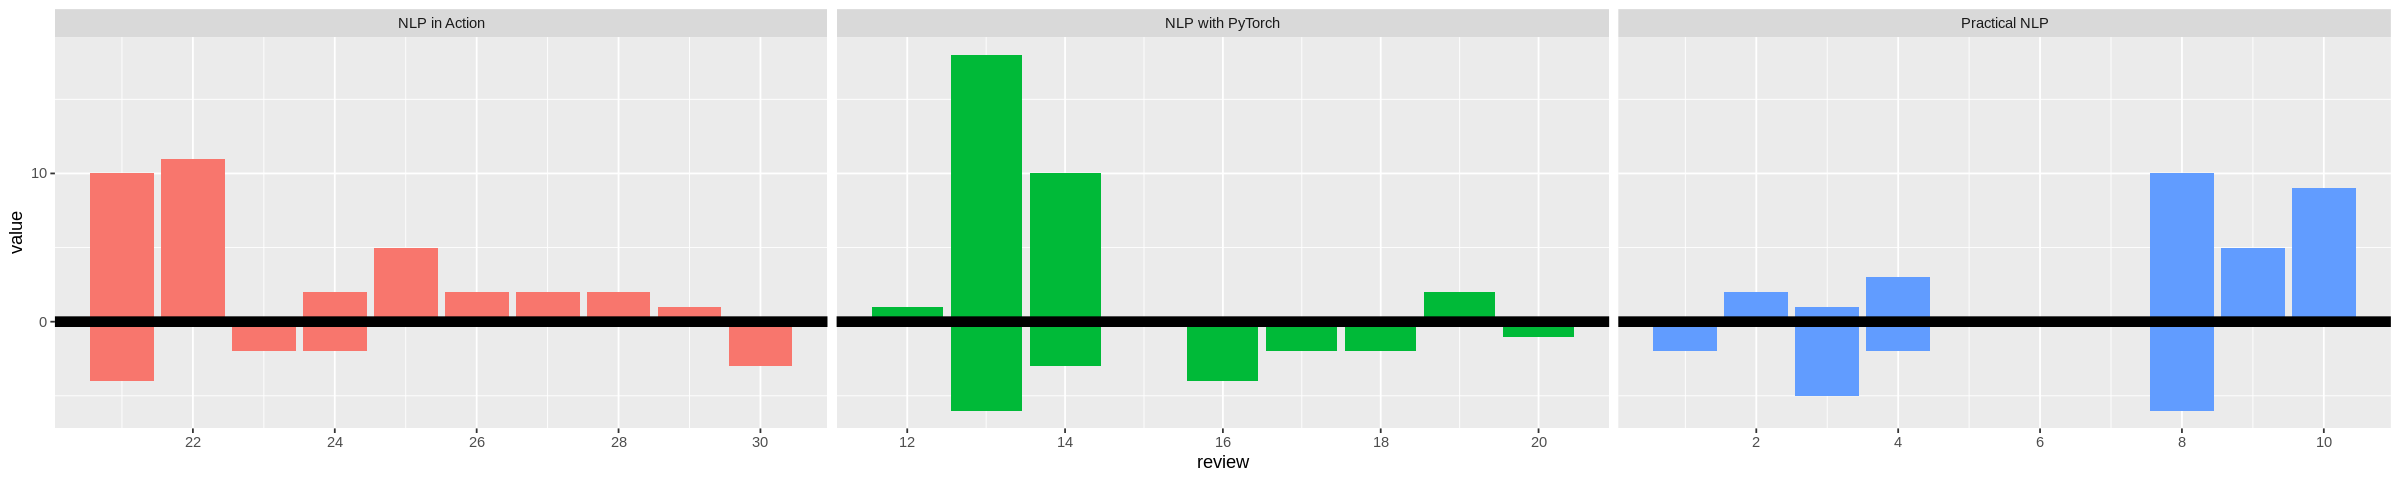

In [140]:
library(ggplot2)
library(repr)
library(scales)
options(repr.plot.width = 20, repr.plot.height = 4) # a wider, shorter figure
scored <- clean %>% inner_join(s2)
head(scored)
ggplot(scored, aes(review, value, fill = title)) + 
  geom_col(show.legend = FALSE) + 
  facet_wrap(~title, ncol = 3, scales = "free_x") + 
  scale_x_continuous(breaks = pretty_breaks()) + 
  geom_hline(yintercept = 0, color = "black", size = 3)

This is already more helpful, right? We could try a coloring word cloud with the positive/negative lexicon.

In [146]:
install.packages("reshape2") # for acast, this a new one for us
library(reshape2)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependency ‘plyr’



Attaching package: ‘reshape2’


The following object is masked from ‘package:tidyr’:

    smiths




In [149]:
install.packages("wordcloud") # we already used this in Session 2
library(wordcloud)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Loading required package: RColorBrewer



Joining, by = "word"


title,review,word,sentiment
<chr>,<int>,<chr>,<chr>
Practical NLP,1,authentic,positive
Practical NLP,3,correct,positive
Practical NLP,3,bad,negative
Practical NLP,3,complained,negative
Practical NLP,3,issues,negative
Practical NLP,4,love,positive


word,sentiment,n
<chr>,<chr>,<int>
helpful,positive,4
complex,negative,3
easy,positive,3
love,positive,3
accessible,positive,2
advanced,positive,2


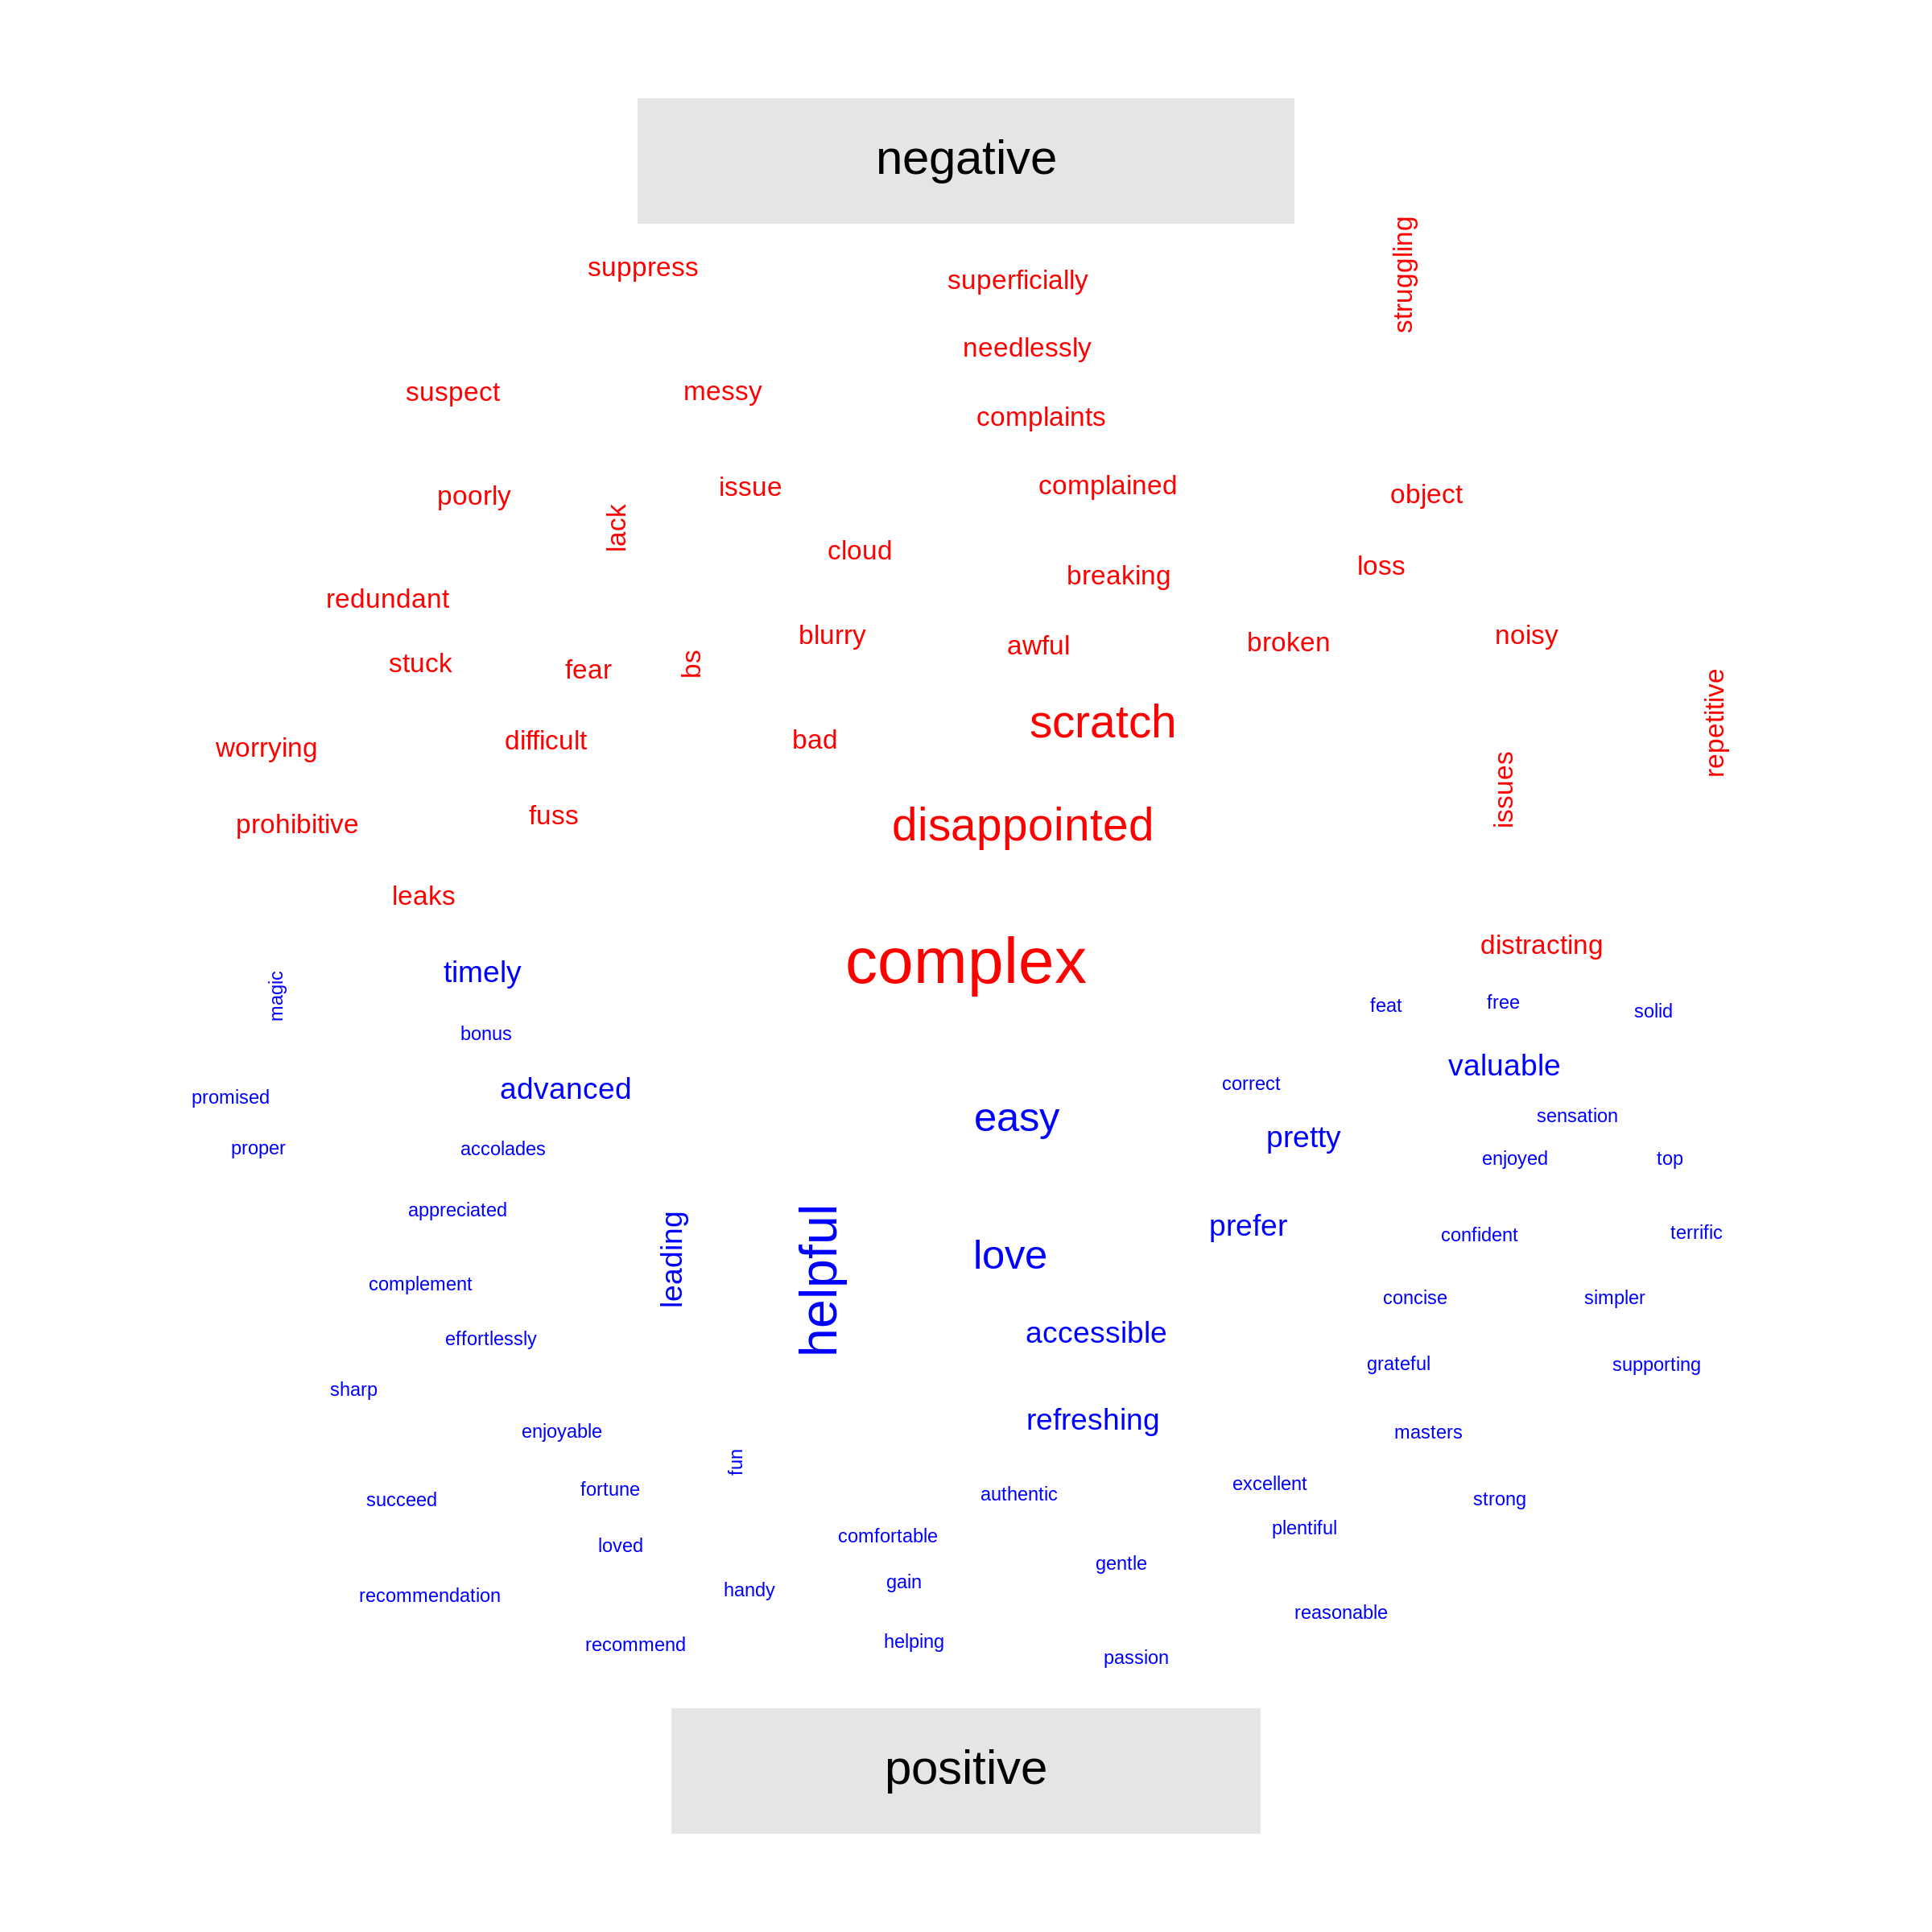

In [167]:
binary <- clean %>% inner_join(s3)
head(binary)
proc <- binary %>% count(word, sentiment, sort = TRUE) # this now combines the three books
head(proc)
options(repr.plot.width = 20, repr.plot.height = 20) # a square figure  
proc %>% acast(word ~ sentiment, value.var = "n", fill = 0) %>% comparison.cloud(colors = c("red", "blue"), max.words = 100)